# RNA FISH analysis example

## **This notebook is just an example to demonstrate how you could analyse your own RNA FISH images.**

Here, we will refer to the official implementation of Mask R-CNN from Matterport with excellent documentations:

https://github.com/matterport/Mask_RCNN

As such, please refer to the official documentation for in-depth explanations and usage of Mask R-CNN, especially if you want to train your own models.

## This example will assume you have a working installation of Mask R-CNN and **your own model!**

# Notes:
If your fresh installation of Mask R-CNN is not working, check your TensorFlow version. You might need to downgrade to TensorFlow 1.

Some additional packages that are used can be installed using pip:
- pandas
- scikit-learn
- seaborn

In [48]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project, (inside the Mask_RCNN folder in this case)
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

**Again, please specify the path to your own model here!**

In [249]:
# Local path to trained weights file
# Please specify the path to your own model here!
MODEL_PATH = os.path.join(ROOT_DIR, "nuclei.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(MODEL_PATH):
    utils.download_trained_weights(MODEL_PATH)

In [252]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + your classes
    DETECTION_MAX_INSTANCES = 500
    DETECTION_MIN_CONFIDENCE = 0.9
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    #MEAN_PIXEL = [0., 0., 0.]

In [109]:
# Initialize model and load trained weights
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=InferenceConfig())
model.load_weights(MODEL_PATH, by_name=True)

### **You can supply the class labels that are present in your model here.**

In [240]:
# should match NUM_CLASSES
class_names = ['BG', 'nucleus']

---

Let's check our trained model on a test image.

**In this notebook, we will just use a quickly-trained nuclei model as an example.** The actual model used in our paper produces significantly better segmentation results.

**It is highly recommended that you train your own models using common nuclei datasets and your own images.**

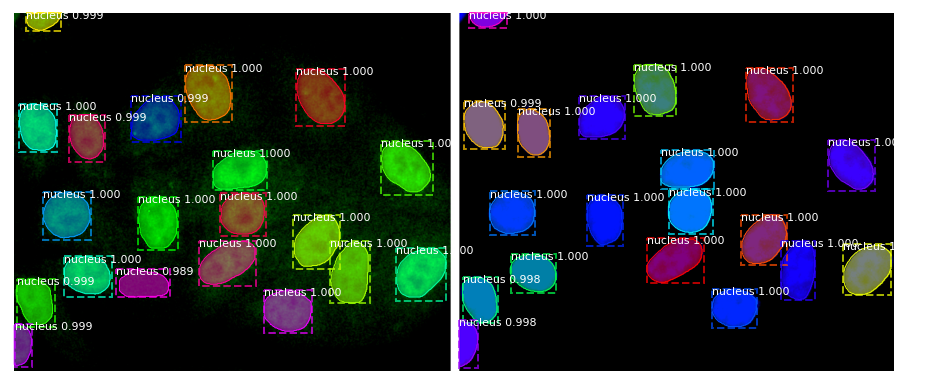

In [242]:
# Load image
image = skimage.io.imread(os.path.join(IMAGE_DIR, '16384'))

# Run detection
results = model.detect([image])

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

Excellent results on the test image!

---

Let's proceed with an example image from our RNA FISH experiments.

## Note:
**In this example, we only performed some basic image processing steps on the image channels capturing the RNA FISH signals.**

Additional image and/or mask processing steps can contribute to a better segmentation and analysis results.

**You might need to process your images in an appropriate way.**

## Let's inspect our RNA FISH image.

In [93]:
stack = skimage.io.imread(os.path.join(IMAGE_DIR, 'Stack1p.tif'))
stack.shape, stack.dtype

((485, 457, 4), dtype('uint16'))

In [201]:
stack_nuclei = stack[:,:,2]
stack_probe1 = stack[:,:,0]
stack_probe2 = stack[:,:,1]
stack_probe3 = stack[:,:,3]

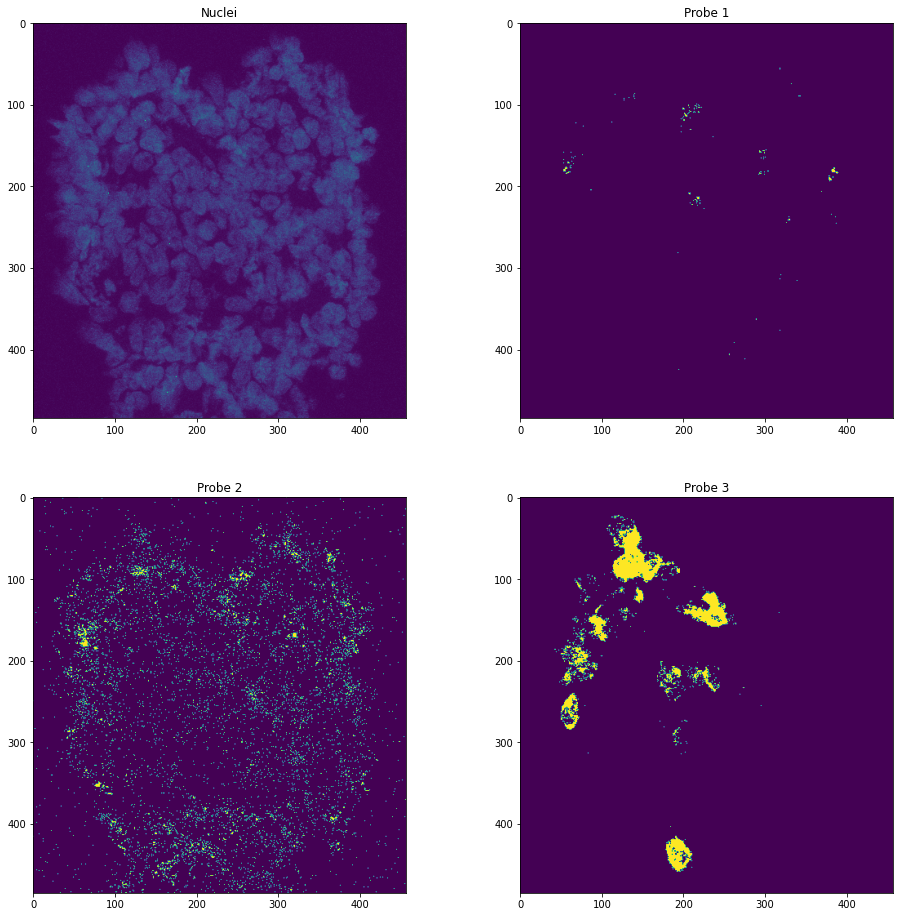

In [214]:
f = plt.figure(figsize=(16,16))

ax1 = f.add_subplot(2,2, 1)
plt.imshow(stack_nuclei)
ax2 = f.add_subplot(2,2, 2)
plt.imshow(stack_probe1)
ax3 = f.add_subplot(2,2, 3)
plt.imshow(stack_probe2)
ax4 = f.add_subplot(2,2, 4)
plt.imshow(stack_probe3)

ax1.set_title('Nuclei')
ax2.set_title('Probe 1')
ax3.set_title('Probe 2')
ax4.set_title('Probe 3')

plt.show(block=True)

Images are loaded correctly, let's run Mask R-CNN on it and extract the masks.

## Note: This implementation of Mask R-CNN requires images with 3 channels!

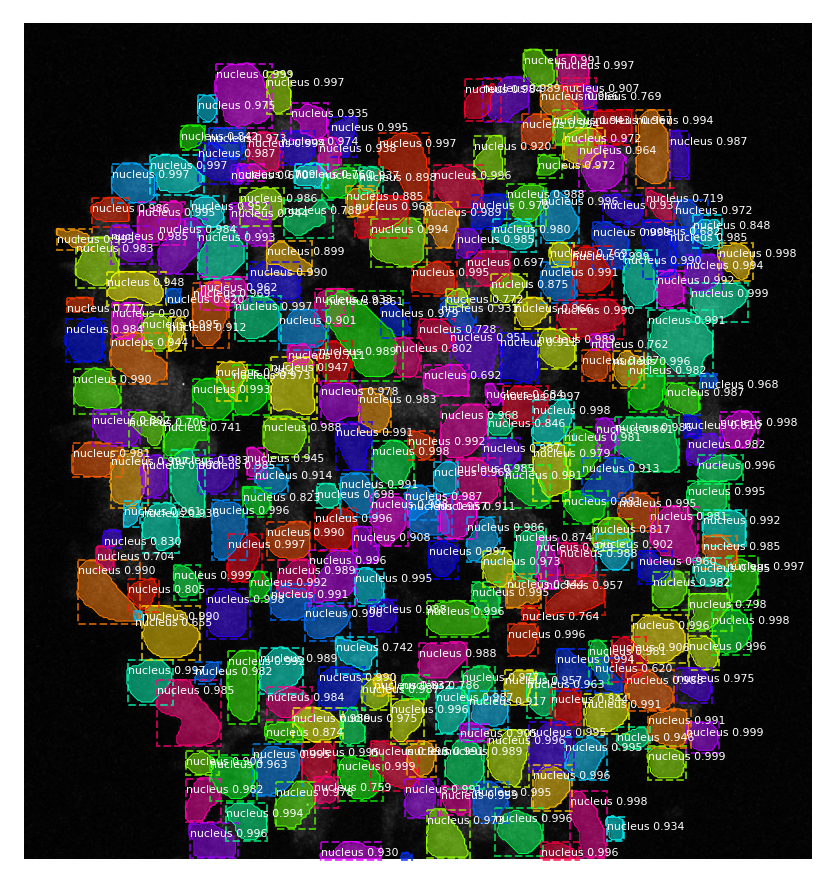

In [250]:
#  Convert gray scale image to RGB for Mask R-CNN
stack_nuclei_rgb = skimage.color.gray2rgb(skimage.img_as_ubyte(stack_nuclei, force_copy=True))

# Initialize and load trained weights
model2 = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=InferenceConfig())
model2.load_weights(MODEL_PATH, by_name=True)

# Run detection
results = model2.detect([stack_nuclei_rgb])

# Visualize results
r2 = results[0]

visualize.display_instances(stack_nuclei_rgb, r2['rois'], r2['masks'], r2['class_ids'], 
                            class_names, r2['scores'])

# Basic analyses

Here, we will introduce some basic functions to analyse the FISH signals in each nuclei.

In [243]:
def count_pixels(masks):
    """
    Count the number of pixels for each mask

    input:
        masks: array containing the masks for N nuclei
               (1024, 1024, N)
    return:
        nuclei_pixels: a list of N masks' number of pixels
    """
    N = masks.shape[0]
    nuclei_pixels = []

    for nucleus in range(N):
        mask = masks[nucleus]
        pixels = np.count_nonzero(mask)
        nuclei_pixels.append(pixels)

    return nuclei_pixels

def masked_nuclei(img, masks):
    """
    Keep only one nuclei on the image and mask everything else

    input:
        img: an image in array format
        
        masks: array containing the masks for N nuclei
               (1024, 1024, N)
    return:
        masked_nuclei: an array of masked images
    """
    N = masks.shape[-1]
    masked_nuclei = []
    
    for nucleus in range(N):
        masked = img * masks[:,:,nucleus]
        masked_nuclei.append(masked)

    return np.asarray(masked_nuclei)

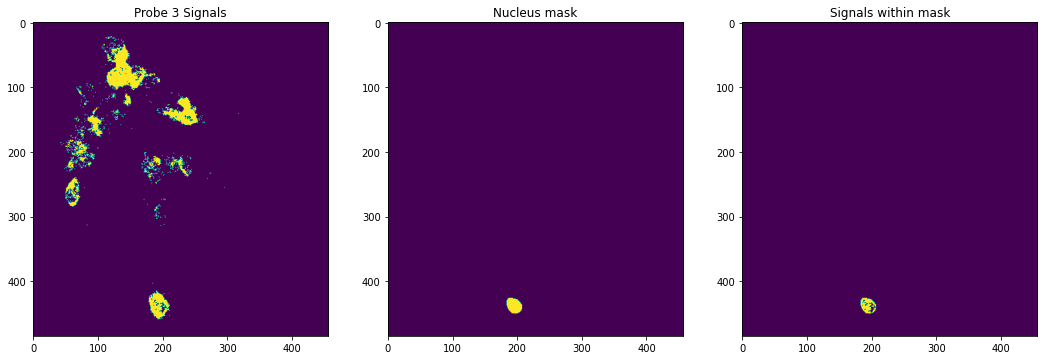

In [251]:
f = plt.figure(figsize=(18,10))
ax1 = f.add_subplot(1,3, 1)
plt.imshow(stack_probe3)
ax2 = f.add_subplot(1,3, 2)
plt.imshow(r2['masks'][:,:,0])
ax3 = f.add_subplot(1,3, 3)
plt.imshow(stack_probe3 * r2['masks'][:,:,0])

ax1.set_title('Probe 3 Signals')
ax2.set_title('Nucleus mask')
ax3.set_title('Signals within mask')

plt.show(block=True)

Let's make a DataFrame that keeps track of the analysis results.

In [244]:
import pandas as pd

df = pd.DataFrame(count_pixels(masked_nuclei(stack_nuclei, r2['masks'])), columns=['nuclei_pixels'])
df['probe1_pixels'] = count_pixels(masked_nuclei(stack_probe1, r2['masks']))
df['probe2_pixels'] = count_pixels(masked_nuclei(stack_probe2, r2['masks']))
df['probe3_pixels'] = count_pixels(masked_nuclei(stack_probe3, r2['masks']))
df

,nuclei_pixels,probe1_pixels,probe2_pixels,probe3_pixels
0,456,0,61,374
1,502,0,63,0
2,202,0,14,0
3,401,0,23,0
4,322,0,33,0
...,...,...,...,...
262,78,0,0,0
263,465,0,31,0
264,77,0,24,77
265,22,0,3,0


In [245]:
import seaborn as sns
from sklearn.cluster import KMeans
from collections import Counter

### Inspecting the data

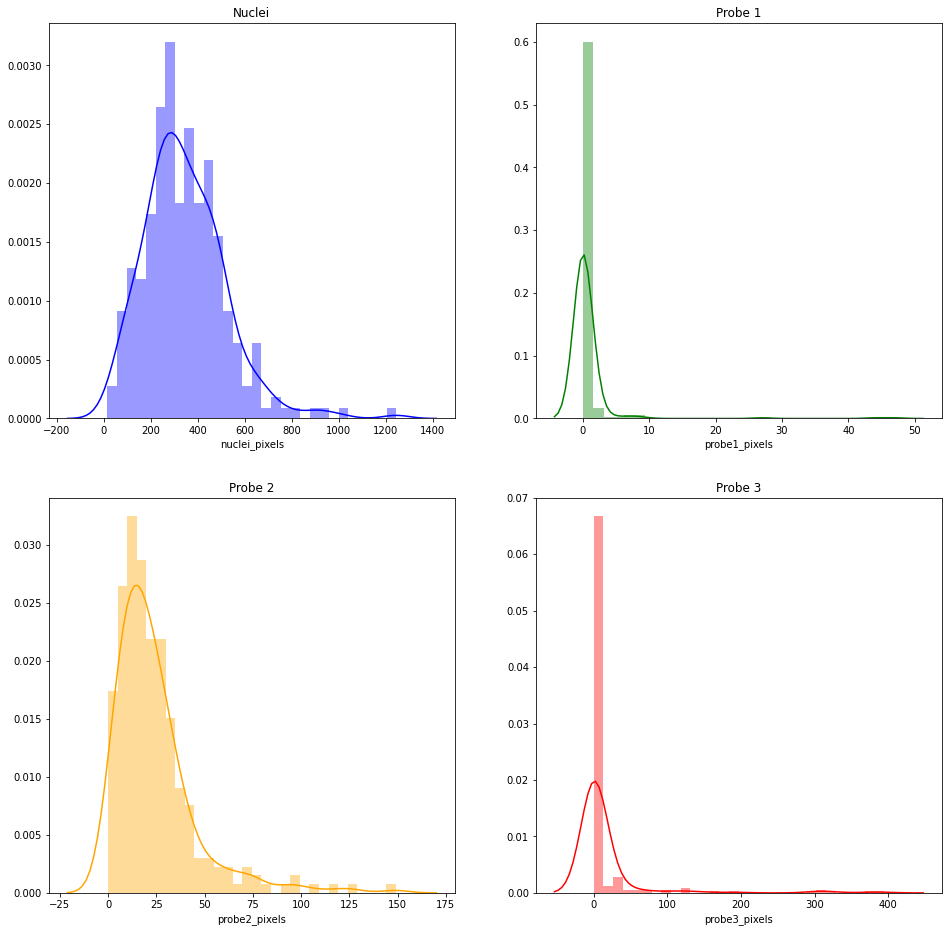

In [230]:
f = plt.figure(figsize=(16,16))

bs = 30

ax1 = f.add_subplot(2,2, 1)
sns.distplot(df['nuclei_pixels'], color='blue', bins=bs)
ax2 = f.add_subplot(2,2, 2)
sns.distplot(df['probe1_pixels'], color='green', bins=bs)
ax3 = f.add_subplot(2,2, 3)
sns.distplot(df['probe2_pixels'], color='orange', bins=bs)
ax4 = f.add_subplot(2,2, 4)
sns.distplot(df['probe3_pixels'], color='red', bins=bs)

ax1.set_title('Nuclei')
ax2.set_title('Probe 1')
ax3.set_title('Probe 2')
ax4.set_title('Probe 3')

plt.show(block=True)

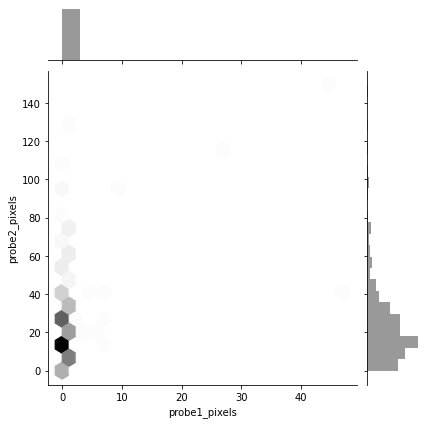

In [247]:
sns.jointplot('probe1_pixels', 'probe2_pixels', data=df, kind='hex', color='k')

Now you can proceed with your own analyses!